In [55]:
import networkx as nx
from networkx.algorithms import bipartite
import random
import os
import matplotlib as plt

# GetBinary

Funcion que dado un entero positivo, lo convierte a su representacion binaria en un arreglo de n bits

In [2]:
def getbinary(num,bits):
  return [int(bit) for bit in format(num,'b').zfill(bits)]

In [77]:
def fuerza_bruta(G):
    
    n = len(bipartite.sets(G)[0])
    clausulas = bipartite.sets(G)[1]
    m = len(clausulas)

    best = 0
    max = 0

    # Evaluamos todas las posibles soluciones
    for i in range(2**n):

        solucion = getbinary(i,n)
        # print(f'solucion {i}')
        clausulas_sat = 0
        for clausula in clausulas:
            
            for variable in G[clausula]:
                # Si la variable 'variable' de la clausula 'G[clausula]' satisface dicha clausula, 
                # terminar de evaluar la clausula
                if G[clausula][variable]['weight'] == 1 and solucion[variable - 1] == 1 or G[clausula][variable]['weight'] == -1 and solucion[variable - 1] == 0:

                    clausulas_sat = clausulas_sat + 1
                    break

        if clausulas_sat > max:
            max = clausulas_sat
            best = solucion

    # print(f'la solucion chida es {best} con {max} clausulas satisfechas de {m}')

    return (best,max)

# GenCaso3Sat (ahora max sat)

Dado un entero n (para variables), un entero m (para clausulas) y una cadena (para nombrar el archivo de salida), genera un archivo con un caso aleatorio de max sat en formato estandar de cnf

In [75]:
def gencaso3sat(n,m,filename):

    with open(filename,'w') as f:
        f.write(f'p cnf {n} {m}\n')
        for _ in range(m):
            cantidad_variables = random.randint(2,m//2) # aqui se puede configurar a 2 sat, 3 sat, etc.
            variables_usadas = []
            clausula = ''
            for _ in range(cantidad_variables): # Pero habria que cambiar esta logica por un while, para garantizar los 2 sat, 3 sat, etc.
                v = random.randint(1,n)         # siempre y cuando la cantidad de variables sea mayor que k-sat
                if v not in variables_usadas: 
                    variables_usadas.append(v)

                    v = v * (1 if random.random() < random.random() else -1)
                    clausula += (str(v) + ' ')
            
            clausula += '0\n'
            f.write(clausula)

In [76]:
for i in range(10):
    name = 'test-cases/test'
    name += str(i)
    name += '.cnf'
    gencaso3sat(5,20,name)

# Evaluando casos de prueba por fuerza bruta

In [ ]:
folder = 'test-cases/'
test_cases = {}

for filename in os.listdir(folder):

    with open(folder+filename) as f:
        
        # Omitir comentarios del archivo
        line = f.readline()
        while line.split()[0] != 'p':
            line = f.readline()

        # leer numero de variables y clausulas
        info = line.split()
        n = int(info[2])
        m = int(info[3])


        variables = [i+1 for i in range(n)]
        clausulas = [i for i in range(n+1,n+1+m)]

        aristas = []

        G = nx.Graph()

        G.add_nodes_from(variables,bipartite=0)
        G.add_nodes_from(clausulas,bipartite=1)

        i = n+1

        for j in range(m):
            clausula_i = f.readline().split()
            
            for v in clausula_i:
                if v != '0':
                    aristas.append((abs(int(v)),i,1 if int(v) >= 0 else -1))
            i = i + 1

        G.add_weighted_edges_from(aristas)

        next = False

        # Si existen nodos aislados (en variables, evitar caso de prueba)
        for node in list(G):
            if G.degree[node] <= 0:
                next = True
                print(f'nodo = {node} | grado = {G.degree[node]}')

        if not next:
            if folder+filename not in test_cases:
                test_cases[folder+filename] = {'G':G,'variables':n,'clausulas':m,'mejor_solucion':0,'satisf':0}

            print(f'evaluando a {folder+filename}')
            best,max = fuerza_bruta(G)

            test_cases[folder+filename]['mejor_solucion']=best
            test_cases[folder+filename]['satisf']=max

            
            print(f'{filename} satisf = {max} clausulas de {m} clausulas')            

In [69]:
def menos_peor_max_sat_k_clausulas(G,k):
  
  # Si hay al menos 2k clausulas, es un caso Si
  if len(bipartite.sets(G)[1]) >= 2*k:
    print('Si hay al menos 2k clausulas, es un caso Si')
    return True

  # Si existe un matching maximal de k o mas aristas, es un caso Si
  if len(nx.maximal_matching(G)) >= k:
    print('Si existe un matching maximal de k o mas aristas, es un caso Si')
    return True

  # Si n <= k, entonces no hay nada que demostrar, kernel deseado
  if len(bipartite.sets(G)[0]) <= k:

    # Calculamos el matching de G
    matching = sorted(nx.maximal_matching(G),key=lambda x: x[0])

    # Guardamos que variables existen en ese matching
    variables_matching = [x[0] for x in matching]
    
    variables_no_matching = []

    # Verificar todas las variables en G, para encontrar
    # aquellas que no esten en el matching
    for variable in bipartite.sets(G)[0]:
      if variable not in variables_matching:
        variables_no_matching.append(variable)

    if len(variables_no_matching) == 0:
      print('Si n <= k, tenemos el kernel deseado')
      return None
    else:
      print('ya casi')

{(5, 8), (4, 9), (1, 7), (2, 6), (3, 11)}
Si n <= k, tenemos el kernel deseado
None


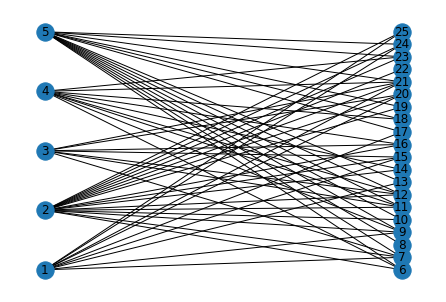

In [53]:
# si hay 20 clausulas y asigno k = 9, es caso si

G = test_cases['test-cases/test420.txt']['G']
print(nx.maximal_matching(G))

top = bipartite.sets(G)[0]
layout = nx.bipartite_layout(G,top)
nx.draw(G,pos=layout,with_labels=True)
# test_cases['test-cases/test1596.txt']
print(menos_peor_max_sat_k_clausulas(G, 11))



{1: 7, 2: 8, 4: 9, 5: 10, 6: 11, 7: 1, 8: 2, 9: 4, 10: 5, 11: 6}
[(1, 7), (2, 8), (4, 9), (5, 10), (6, 11)]
[1, 2, 4, 5, 6]
[3]


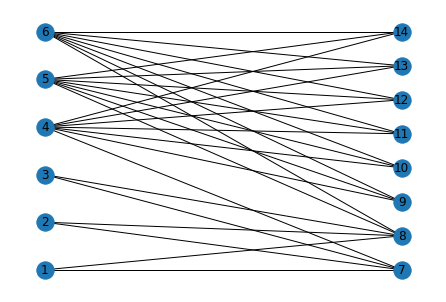

In [66]:
variables = [1,2,3,4,5,6]
clausulas = [7,8,9,10,11,12,13,14]
aristas = [ (1,7),(1,8),
            (2,7),(2,8),
            (3,7),(3,8),
            (4,7),(4,9),(4,10),(4,11),(4,12),(4,13),(4,14),
            (5,8),(5,9),(5,10),(5,11),(5,12),(5,13),(5,14),
            (6,8),(6,9),(6,10),(6,11),(6,12),(6,13),(6,14)]

H = nx.Graph()
H.add_nodes_from(variables,bipartite=0)
H.add_nodes_from(clausulas,bipartite=1)
H.add_edges_from(aristas)

top = bipartite.sets(H)[0]
layout = nx.bipartite_layout(H,top)
nx.draw(H,pos=layout,with_labels=True)


print(bipartite.hopcroft_karp_matching(H,top_nodes=top))
matching = sorted(nx.maximal_matching(H),key=lambda x: x[0])
print(matching)
variables_matching = [x[0] for x in matching]
print(variables_matching)

notin = []

for v in bipartite.sets(H)[0]:
    if v not in variables_matching:
        notin.append(v)

print(notin)


In [73]:
if len(notin) > 0:
    v = notin[0]
    visitados = []
    visitados.append(v)
    #while True:
    vecinos = list(H[v])
    print(vecinos[0])


7
